In [1]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_style('darkgrid')

from tqdm import tqdm_notebook as tqdm

from utils import show_single_frame, show_multiply_frames, get_frames, draw_rois

### Load images

In [2]:
frames, gray_frames = get_frames('./data/sheptytsky_center/')

**Frame 1**

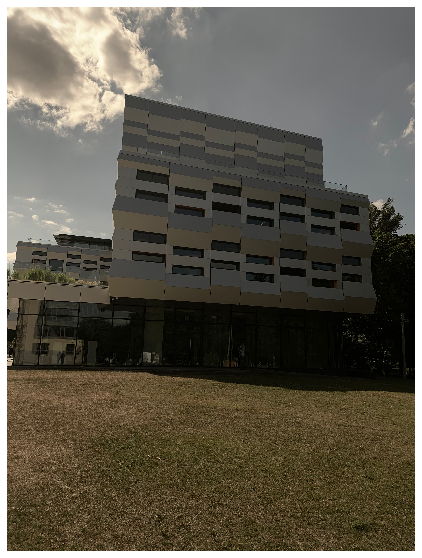

In [23]:
show_single_frame(frames[4], '')

**Frame 2**

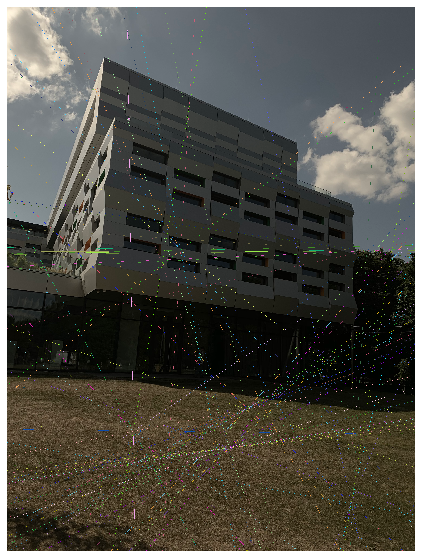

In [37]:
show_single_frame(frames[10], '')

### Code for finding epipole lines

In [13]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' 
        Taken from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
        img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:2]
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2

def find_epipole(img1, img2, opencv=True, max_points=8):
    
    # get features
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(img1, None)
    kp2, desc2 = sift.detectAndCompute(img2, None)

    # match points between images
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    good = []
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
        if len(good) == max_points:
            break
    
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    
    # compute fundamental matrix
    if opencv:
        fundamental_matrix, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
        pts1 = pts1[mask.ravel()==1]
        pts2 = pts2[mask.ravel()==1]
    else:
        num_points = min(max_points, len(matches))
        x1 = np.zeros((num_points, 2))
        x2 = np.zeros((num_points, 2))
        for i in range(num_points):
            x1_idx, x2_idx = matches[i][0].queryIdx, matches[i][0].trainIdx
            x1[i] = np.array(kp1[x1_idx].pt)
            x2[i] = np.array(kp2[x2_idx].pt)
        t = np.mean(x1, 0)
        x1_demeaned = x1 - t
        s = np.sqrt(2) / np.linalg.norm(x1_demeaned, axis=1).mean()
        t1 = np.array([[s, 0, -s*t[0]],
                      [0, s, -s*t[1]],
                      [0, 0,  1]])
        x1 = x1_demeaned*s
        t = np.mean(x2, 0)
        x2_demeaned = x2 - t
        s = np.sqrt(2) / np.linalg.norm(x2_demeaned, axis=1).mean()
        t2 = np.array([[s, 0, -s*t[0]],
                      [0, s, -s*t[1]],
                      [0, 0,  1]])
        x2 = x2_demeaned*s
        matrix = np.stack((x1[:, 0]*x2[:, 0], x1[:, 0]*x2[:, 1], x1[:, 0], x1[:, 1]*x1[:, 0], 
                           x1[:, 1]*x2[:, 1], x1[:, 1], x2[:, 0], x2[:, 1], np.ones(num_points)), 1)
        u, s, v = np.linalg.svd(matrix)
        matrix = v[:, -1].reshape(3, 3)
        u, s, v = np.linalg.svd(matrix, False)
        matrix = u.dot(np.diag((s[0], s[1], 0)).dot(v))
        fundamental_matrix = t2.T.dot(matrix).dot(t1)

    # find and draw lines
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
    lines1 = lines1.reshape(-1, 3)
    img3, _ = drawlines(img1, img2, lines1, pts1, pts2)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
    lines2 = lines2.reshape(-1, 3)
    img5, _ = drawlines(img2, img1, lines2, pts2, pts1)
    
    return img3, img5

### Results

**Custom**

In [30]:
img1, img2 = find_epipole(frames[4], frames[10], opencv=False, max_points=20)

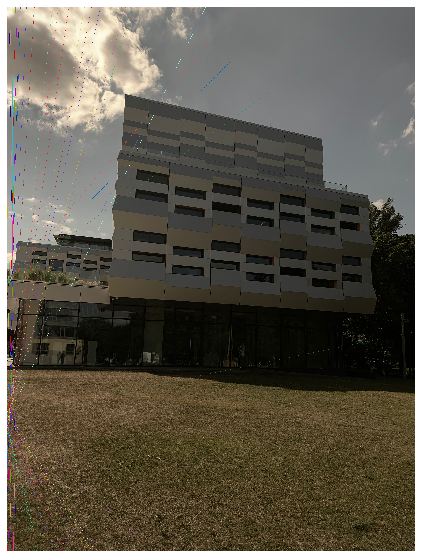

In [31]:
show_single_frame(img1, '')

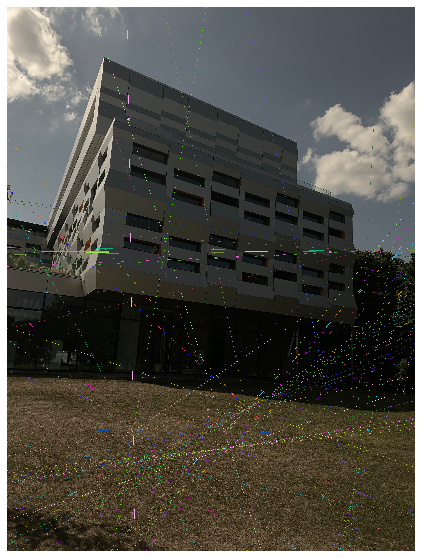

In [32]:
show_single_frame(img2, '')

**Opencv**

In [33]:
img1, img2 = find_epipole(frames[4], frames[10], opencv=True, max_points=20)

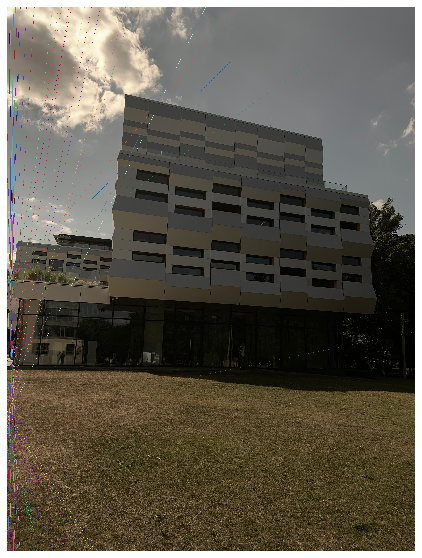

In [34]:
show_single_frame(img1, '')

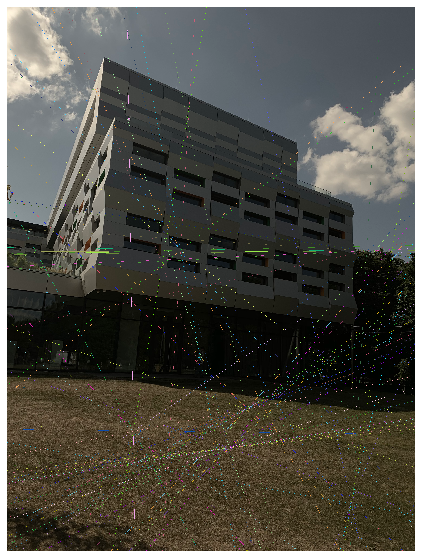

In [35]:
show_single_frame(img2, '')